# SVM: Version 4

## SVM with PCA and Adaptive Thresholding

In [19]:
import cv2
import os
import glob
import time
import random
import mlflow
import shutil
import itertools

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image
from sklearn.decomposition import PCA
from sklearn import svm
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.metrics import (
    make_scorer,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
)

In [2]:
TRAIN_DIR = "../data/train"
CLASS_FOLDERS = ["Class A", "Class B", "Class C", "Class D"]
ML_FLOW_DIRECTORY = "SVM_Logs"

In [5]:
mlflow.set_tracking_uri(ML_FLOW_DIRECTORY)
mlflow.set_experiment("SVM_PCA_adaptive_thresholding")

<Experiment: artifact_location='/Users/jacob/Code/Monkey-Business/SVM/SVM_Logs/406276998162136415', creation_time=1701977597424, experiment_id='406276998162136415', last_update_time=1701977597424, lifecycle_stage='active', name='SVM_PCA_adaptive_thresholding', tags={}>

In [6]:
pca_components = [40 * 40, 45 * 45, 50 * 50]
C_values = [0.1, 1, 10]
kernel_types = ["linear", "rbf"]
gamma_values = ["scale", "auto"]

In [7]:
hyperparameter_combinations = list(
    itertools.product(pca_components, C_values, kernel_types, gamma_values)
)
print(
    f"Total number of hyperparameter combinations: {len(hyperparameter_combinations)}"
)

Total number of hyperparameter combinations: 36


In [8]:
pca_models_dict = {}

In [9]:
def train_with_params(pca_components, C, kernel, gamma, train_images, train_labels):
    # Check if PCA model for pca_components already exists
    if pca_components in pca_models_dict:
        pca = pca_models_dict[pca_components]
        print(f"Using existing PCA model for {pca_components} components")
    else:
        # Apply PCA
        pca = PCA(n_components=pca_components)
        pca.fit(train_images)
        pca_models_dict[pca_components] = pca

    # Transform images with PCA
    train_images_pca = pca.transform(train_images)

    with mlflow.start_run() as run:
        start_time = time.time()

        # Initialize SVM model
        svm_model = svm.SVC(
            C=C, kernel=kernel, gamma=gamma, class_weight="balanced", verbose=True
        )

        # Perform cross-validation
        skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
        scoring = {
            "f1_weighted": make_scorer(f1_score, average="weighted"),
            "accuracy": "accuracy",
            "precision": make_scorer(precision_score, average="weighted"),
            "recall": make_scorer(recall_score, average="weighted"),
        }
        cv_results = cross_validate(
            svm_model,
            train_images_pca,
            train_labels,
            cv=skf,
            scoring=scoring,
            verbose=2,
        )

        # Log hyperparameters and metrics
        mlflow.log_params(
            {"pca_components": pca_components, "C": C, "kernel": kernel, "gamma": gamma}
        )
        mlflow.log_metrics(
            {
                "mean_f1_weighted": cv_results["test_f1_weighted"].mean(),
                "mean_accuracy": cv_results["test_accuracy"].mean(),
                "mean_precision": cv_results["test_precision"].mean(),
                "mean_recall": cv_results["test_recall"].mean(),
            }
        )
        end_time = time.time()
        duration = end_time - start_time
        param_details = f"PCA={pca_components}, C={C}, kernel={kernel}, gamma={gamma}"
        duration_details = f"Training duration for {param_details}: {duration} seconds"
        print(duration_details)
        run_id = run.info.run_id
        return run_id

In [12]:
def remove_background_with_threshold(image_path):
    image = cv2.imread(image_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    mask = cv2.adaptiveThreshold(
        gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11, 2
    )
    mask = cv2.bitwise_not(mask)
    alpha = cv2.merge([mask] * 3)
    result = cv2.bitwise_and(image, alpha)
    return result

In [13]:
def load_images_from_folder(folder):
    images = []
    labels = []
    for class_folder in CLASS_FOLDERS:
        start_time = time.time()
        class_path = os.path.join(folder, class_folder)
        image_files = glob.glob(os.path.join(class_path, "*.png"))
        for img_file in image_files:
            processed_image = remove_background_with_threshold(img_file)
            flattened_image = processed_image.flatten()
            images.append(flattened_image)
            labels.append(class_folder)
        end_time = time.time()
        duration = end_time - start_time
        print(f"Processing {class_folder} took {duration} seconds")
    return np.array(images), np.array(labels)

In [14]:
train_images, train_labels = load_images_from_folder(TRAIN_DIR)

Processing Class A took 1.7447788715362549 seconds
Processing Class B took 0.9775938987731934 seconds
Processing Class C took 0.6609561443328857 seconds
Processing Class D took 0.8075709342956543 seconds


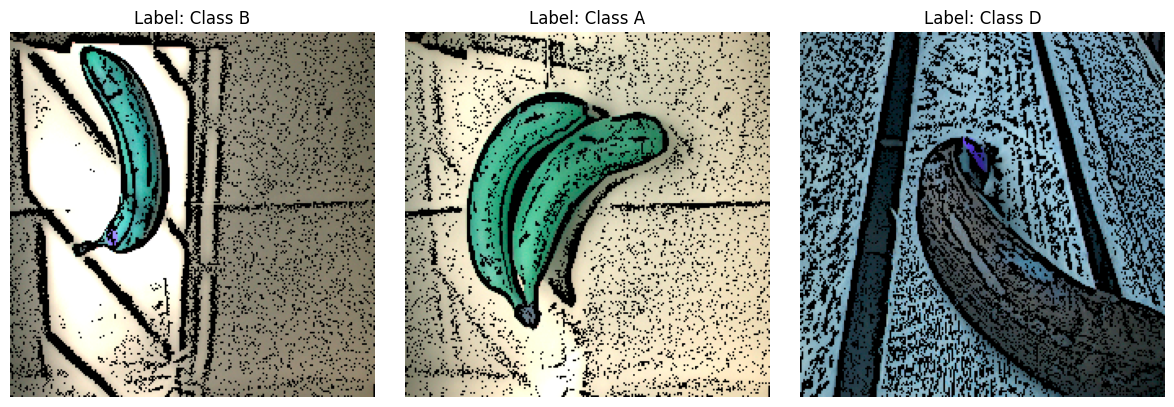

In [20]:
random_indices = random.sample(range(len(train_images)), 3)
fig, axs = plt.subplots(1, 3, figsize=(12, 4))
for i, idx in enumerate(random_indices):
    image = train_images[idx].reshape(
        224, 224, 3
    )
    label = train_labels[idx]

    axs[i].imshow(image)
    axs[i].set_title(f"Label: {label}")
    axs[i].axis("off")

plt.tight_layout()
plt.show()

In [21]:
print(
    f"Shape of train_images: {train_images.shape}, Shape of train_labels: {train_labels.shape}"
)

Shape of train_images: (2796, 150528), Shape of train_labels: (2796,)


In [22]:
run_ids = []

for params in hyperparameter_combinations:
    pca_components, C, kernel, gamma = params
    run_id = train_with_params(
        pca_components, C, kernel, gamma, train_images, train_labels
    )
    run_ids.append(run_id)

[LibSVM]...*.*
optimization finished, #iter = 4698
obj = -0.000005, rho = 0.428781
nSV = 453, nBSV = 0
*.*
optimization finished, #iter = 1381
obj = -0.000001, rho = -0.450193
nSV = 322, nBSV = 0
.*.*
optimization finished, #iter = 2477
obj = -0.000001, rho = -0.406783
nSV = 354, nBSV = 0
.*.*
optimization finished, #iter = 2104
obj = -0.000001, rho = -0.830624
nSV = 482, nBSV = 0
..*.*
optimization finished, #iter = 2605
obj = -0.000002, rho = -0.642354
nSV = 424, nBSV = 0
.*.*
optimization finished, #iter = 1811
obj = -0.000001, rho = 0.337331
nSV = 462, nBSV = 0
Total nSV = 1303
[CV] END .................................................... total time=   2.9s
[LibSVM]...*.*
optimization finished, #iter = 4705
obj = -0.000005, rho = 0.334752
nSV = 443, nBSV = 0
*.*
optimization finished, #iter = 1311
obj = -0.000000, rho = -0.413139
nSV = 341, nBSV = 0
.*.*
optimization finished, #iter = 2061
obj = -0.000001, rho = -0.480092
nSV = 361, nBSV = 0
.*.*
optimization finished, #iter = 1944

/Users/jacob/.pyenv/versions/anaconda3-2022.10/envs/monkey-business/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END .................................................... total time=   5.5s
[LibSVM].*
optimization finished, #iter = 1194
obj = -89.260346, rho = 0.892874
nSV = 1197, nBSV = 1194
.
*
optimization finished, #iter = 1058
obj = -88.112835, rho = 0.843624
nSV = 1060, nBSV = 762
.*
optimization finished, #iter = 1130
obj = -88.797951, rho = 0.747425
nSV = 1131, nBSV = 1130
*
optimization finished, #iter = 732
obj = -87.060397, rho = -0.892874
nSV = 733, nBSV = 732
*
optimization finished, #iter = 803
obj = -87.745512, rho = -0.892874
nSV = 804, nBSV = 803
*
optimization finished, #iter = 666
obj = -86.598001, rho = -0.843624
nSV = 667, nBSV = 666
Total nSV = 1864


/Users/jacob/.pyenv/versions/anaconda3-2022.10/envs/monkey-business/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END .................................................... total time=   5.5s
[LibSVM].*
optimization finished, #iter = 1196
obj = -89.275306, rho = 0.892874
nSV = 1197, nBSV = 1196
.*
optimization finished, #iter = 1059
obj = -88.103341, rho = 0.687248
nSV = 1060, nBSV = 1059
.*
optimization finished, #iter = 1130
obj = -88.812910, rho = 0.747425
nSV = 1131, nBSV = 1130
*
optimization finished, #iter = 732
obj = -87.035944, rho = -0.892874
nSV = 733, nBSV = 732
*
optimization finished, #iter = 803
obj = -87.745512, rho = -0.892874
nSV = 804, nBSV = 803
*
optimization finished, #iter = 666
obj = -86.573548, rho = -0.687248
nSV = 667, nBSV = 666
Total nSV = 1864


/Users/jacob/.pyenv/versions/anaconda3-2022.10/envs/monkey-business/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END .................................................... total time=   5.5s
Training duration for PCA=1600, C=0.1, kernel=rbf, gamma=auto: 16.570104122161865 seconds
Using existing PCA model for 1600 components
[LibSVM]...*.*
optimization finished, #iter = 4698
obj = -0.000005, rho = 0.428781
nSV = 453, nBSV = 0
*.*
optimization finished, #iter = 1381
obj = -0.000001, rho = -0.450193
nSV = 322, nBSV = 0
.*.*
optimization finished, #iter = 2477
obj = -0.000001, rho = -0.406783
nSV = 354, nBSV = 0
.*.*
optimization finished, #iter = 2104
obj = -0.000001, rho = -0.830624
nSV = 482, nBSV = 0
..*.*
optimization finished, #iter = 2605
obj = -0.000002, rho = -0.642354
nSV = 424, nBSV = 0
.*.*
optimization finished, #iter = 1811
obj = -0.000001, rho = 0.337331
nSV = 462, nBSV = 0
Total nSV = 1303
[CV] END .................................................... total time=   2.9s
[LibSVM]...*.*
optimization finished, #iter = 4705
obj = -0.000005, rho = 0.334752
nSV = 443, nBSV = 0
*.*
optimiz

/Users/jacob/.pyenv/versions/anaconda3-2022.10/envs/monkey-business/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END .................................................... total time=   5.6s
[LibSVM].*
optimization finished, #iter = 1666
obj = -538.248782, rho = -0.067917
nSV = 1197, nBSV = 752
.*.*
optimization finished, #iter = 2733
obj = -427.651130, rho = -0.435071
nSV = 1055, nBSV = 0
.*
optimization finished, #iter = 1543
obj = -493.181068, rho = -0.259741
nSV = 1130, nBSV = 752
.*.*
optimization finished, #iter = 1698
obj = -353.697052, rho = -0.186903
nSV = 733, nBSV = 0
..*.*
optimization finished, #iter = 2674
obj = -398.704789, rho = -0.083437
nSV = 803, nBSV = 0
..*.*
optimization finished, #iter = 2018
obj = -329.321247, rho = 0.105105
nSV = 666, nBSV = 0
Total nSV = 1863


/Users/jacob/.pyenv/versions/anaconda3-2022.10/envs/monkey-business/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END .................................................... total time=   5.5s
[LibSVM].*
optimization finished, #iter = 1492
obj = -539.573810, rho = -0.070589
nSV = 1197, nBSV = 760
..*
optimization finished, #iter = 2463
obj = -427.253254, rho = -0.438563
nSV = 1058, nBSV = 0
.*
optimization finished, #iter = 1691
obj = -494.124509, rho = -0.389316
nSV = 1130, nBSV = 521
.*.*
optimization finished, #iter = 1971
obj = -352.991787, rho = -0.188525
nSV = 732, nBSV = 0
..*.*
optimization finished, #iter = 2674
obj = -398.704789, rho = -0.083437
nSV = 803, nBSV = 0
..*.*
optimization finished, #iter = 2139
obj = -328.709704, rho = 0.106767
nSV = 665, nBSV = 0
Total nSV = 1863


/Users/jacob/.pyenv/versions/anaconda3-2022.10/envs/monkey-business/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END .................................................... total time=   5.5s
Training duration for PCA=1600, C=1, kernel=rbf, gamma=auto: 16.647215127944946 seconds
Using existing PCA model for 1600 components
[LibSVM]...*.*
optimization finished, #iter = 4698
obj = -0.000005, rho = 0.428781
nSV = 453, nBSV = 0
*.*
optimization finished, #iter = 1381
obj = -0.000001, rho = -0.450193
nSV = 322, nBSV = 0
.*.*
optimization finished, #iter = 2477
obj = -0.000001, rho = -0.406783
nSV = 354, nBSV = 0
.*.*
optimization finished, #iter = 2104
obj = -0.000001, rho = -0.830624
nSV = 482, nBSV = 0
..*.*
optimization finished, #iter = 2605
obj = -0.000002, rho = -0.642354
nSV = 424, nBSV = 0
.*.*
optimization finished, #iter = 1811
obj = -0.000001, rho = 0.337331
nSV = 462, nBSV = 0
Total nSV = 1303
[CV] END .................................................... total time=   2.9s
[LibSVM]...*.*
optimization finished, #iter = 4705
obj = -0.000005, rho = 0.334752
nSV = 443, nBSV = 0
*.*
optimizat

/Users/jacob/.pyenv/versions/anaconda3-2022.10/envs/monkey-business/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END .................................................... total time=   5.6s
[LibSVM]..*.*
optimization finished, #iter = 3801
obj = -552.508255, rho = -0.270134
nSV = 1192, nBSV = 0
.*.*
optimization finished, #iter = 2946
obj = -427.651059, rho = -0.435071
nSV = 1055, nBSV = 0
..*.*
optimization finished, #iter = 3419
obj = -495.246184, rho = -0.345778
nSV = 1125, nBSV = 0
.*.*
optimization finished, #iter = 1698
obj = -353.697052, rho = -0.186903
nSV = 733, nBSV = 0
..*.*
optimization finished, #iter = 2682
obj = -398.704762, rho = -0.083437
nSV = 803, nBSV = 0
..*.*
optimization finished, #iter = 2018
obj = -329.321247, rho = 0.105105
nSV = 666, nBSV = 0
Total nSV = 1858


/Users/jacob/.pyenv/versions/anaconda3-2022.10/envs/monkey-business/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END .................................................... total time=   5.5s
[LibSVM]..*.*
optimization finished, #iter = 3849
obj = -553.570175, rho = -0.272575
nSV = 1196, nBSV = 0
.*.*
optimization finished, #iter = 2711
obj = -427.253267, rho = -0.438563
nSV = 1058, nBSV = 0
..*.*
optimization finished, #iter = 3629
obj = -496.099070, rho = -0.348096
nSV = 1129, nBSV = 0
.*.*
optimization finished, #iter = 1971
obj = -352.991787, rho = -0.188525
nSV = 732, nBSV = 0
..*.*
optimization finished, #iter = 2682
obj = -398.704762, rho = -0.083437
nSV = 803, nBSV = 0
..*.*
optimization finished, #iter = 2139
obj = -328.709704, rho = 0.106767
nSV = 665, nBSV = 0
Total nSV = 1861


/Users/jacob/.pyenv/versions/anaconda3-2022.10/envs/monkey-business/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END .................................................... total time=   5.6s
Training duration for PCA=1600, C=10, kernel=rbf, gamma=auto: 16.678353786468506 seconds
[LibSVM]..*.*
optimization finished, #iter = 3452
obj = -0.000004, rho = 0.263177
nSV = 507, nBSV = 0
*.*
optimization finished, #iter = 1223
obj = -0.000000, rho = -0.420474
nSV = 375, nBSV = 0
.*
optimization finished, #iter = 1974
obj = -0.000001, rho = -0.384882
nSV = 402, nBSV = 0
.*.*
optimization finished, #iter = 1888
obj = -0.000001, rho = -0.704961
nSV = 561, nBSV = 0
.*.*
optimization finished, #iter = 1878
obj = -0.000001, rho = -0.481979
nSV = 498, nBSV = 0
.*.*
optimization finished, #iter = 1502
obj = -0.000001, rho = 0.291898
nSV = 531, nBSV = 0
Total nSV = 1403
[CV] END .................................................... total time=   4.6s
[LibSVM]..*.*
optimization finished, #iter = 3865
obj = -0.000003, rho = 0.231478
nSV = 515, nBSV = 0
*.*
optimization finished, #iter = 1131
obj = -0.000000, rho =

/Users/jacob/.pyenv/versions/anaconda3-2022.10/envs/monkey-business/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END .................................................... total time=   9.3s
[LibSVM].*
optimization finished, #iter = 1194
obj = -89.260346, rho = 0.892874
nSV = 1197, nBSV = 1194
.
*
optimization finished, #iter = 1058
obj = -88.112835, rho = 0.843624
nSV = 1060, nBSV = 762
.*
optimization finished, #iter = 1130
obj = -88.797951, rho = 0.747425
nSV = 1131, nBSV = 1130
*
optimization finished, #iter = 732
obj = -87.060397, rho = -0.892874
nSV = 733, nBSV = 732
*
optimization finished, #iter = 803
obj = -87.745512, rho = -0.892874
nSV = 804, nBSV = 803
*
optimization finished, #iter = 666
obj = -86.598001, rho = -0.843624
nSV = 667, nBSV = 666
Total nSV = 1864


/Users/jacob/.pyenv/versions/anaconda3-2022.10/envs/monkey-business/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END .................................................... total time=   9.2s
[LibSVM].*
optimization finished, #iter = 1196
obj = -89.275306, rho = 0.892874
nSV = 1197, nBSV = 1196
.*
optimization finished, #iter = 1059
obj = -88.103341, rho = 0.687248
nSV = 1060, nBSV = 1059
.*
optimization finished, #iter = 1130
obj = -88.812910, rho = 0.747425
nSV = 1131, nBSV = 1130
*
optimization finished, #iter = 732
obj = -87.035944, rho = -0.892874
nSV = 733, nBSV = 732
*
optimization finished, #iter = 803
obj = -87.745512, rho = -0.892874
nSV = 804, nBSV = 803
*
optimization finished, #iter = 666
obj = -86.573548, rho = -0.687248
nSV = 667, nBSV = 666
Total nSV = 1864


/Users/jacob/.pyenv/versions/anaconda3-2022.10/envs/monkey-business/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END .................................................... total time=   8.6s
Training duration for PCA=2025, C=0.1, kernel=rbf, gamma=auto: 27.1301531791687 seconds
Using existing PCA model for 2025 components
[LibSVM]..*.*
optimization finished, #iter = 3452
obj = -0.000004, rho = 0.263177
nSV = 507, nBSV = 0
*.*
optimization finished, #iter = 1223
obj = -0.000000, rho = -0.420474
nSV = 375, nBSV = 0
.*
optimization finished, #iter = 1974
obj = -0.000001, rho = -0.384882
nSV = 402, nBSV = 0
.*.*
optimization finished, #iter = 1888
obj = -0.000001, rho = -0.704961
nSV = 561, nBSV = 0
.*.*
optimization finished, #iter = 1878
obj = -0.000001, rho = -0.481979
nSV = 498, nBSV = 0
.*.*
optimization finished, #iter = 1502
obj = -0.000001, rho = 0.291898
nSV = 531, nBSV = 0
Total nSV = 1403
[CV] END .................................................... total time=   5.5s
[LibSVM]..*.*
optimization finished, #iter = 3865
obj = -0.000003, rho = 0.231478
nSV = 515, nBSV = 0
*.*
optimization f

/Users/jacob/.pyenv/versions/anaconda3-2022.10/envs/monkey-business/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END .................................................... total time=  10.2s
[LibSVM].*
optimization finished, #iter = 1666
obj = -538.248782, rho = -0.067917
nSV = 1197, nBSV = 752
.*.*
optimization finished, #iter = 2733
obj = -427.651130, rho = -0.435071
nSV = 1055, nBSV = 0
.*
optimization finished, #iter = 1543
obj = -493.181068, rho = -0.259741
nSV = 1130, nBSV = 752
.*.*
optimization finished, #iter = 1698
obj = -353.697052, rho = -0.186903
nSV = 733, nBSV = 0
..*.*
optimization finished, #iter = 2674
obj = -398.704789, rho = -0.083437
nSV = 803, nBSV = 0
..*.*
optimization finished, #iter = 2018
obj = -329.321247, rho = 0.105105
nSV = 666, nBSV = 0
Total nSV = 1863


/Users/jacob/.pyenv/versions/anaconda3-2022.10/envs/monkey-business/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END .................................................... total time=  10.0s
[LibSVM].*
optimization finished, #iter = 1492
obj = -539.573810, rho = -0.070589
nSV = 1197, nBSV = 760
..*
optimization finished, #iter = 2463
obj = -427.253254, rho = -0.438563
nSV = 1058, nBSV = 0
.*
optimization finished, #iter = 1691
obj = -494.124509, rho = -0.389316
nSV = 1130, nBSV = 521
.*.*
optimization finished, #iter = 1971
obj = -352.991787, rho = -0.188525
nSV = 732, nBSV = 0
..*.*
optimization finished, #iter = 2674
obj = -398.704789, rho = -0.083437
nSV = 803, nBSV = 0
..*.*
optimization finished, #iter = 2139
obj = -328.709704, rho = 0.106767
nSV = 665, nBSV = 0
Total nSV = 1863


/Users/jacob/.pyenv/versions/anaconda3-2022.10/envs/monkey-business/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END .................................................... total time=   9.9s
Training duration for PCA=2025, C=1, kernel=rbf, gamma=auto: 30.121676921844482 seconds
Using existing PCA model for 2025 components
[LibSVM]..*.*
optimization finished, #iter = 3452
obj = -0.000004, rho = 0.263177
nSV = 507, nBSV = 0
*.*
optimization finished, #iter = 1223
obj = -0.000000, rho = -0.420474
nSV = 375, nBSV = 0
.*
optimization finished, #iter = 1974
obj = -0.000001, rho = -0.384882
nSV = 402, nBSV = 0
.*.*
optimization finished, #iter = 1888
obj = -0.000001, rho = -0.704961
nSV = 561, nBSV = 0
.*.*
optimization finished, #iter = 1878
obj = -0.000001, rho = -0.481979
nSV = 498, nBSV = 0
.*.*
optimization finished, #iter = 1502
obj = -0.000001, rho = 0.291898
nSV = 531, nBSV = 0
Total nSV = 1403
[CV] END .................................................... total time=   5.1s
[LibSVM]..*.*
optimization finished, #iter = 3865
obj = -0.000003, rho = 0.231478
nSV = 515, nBSV = 0
*.*
optimization f

/Users/jacob/.pyenv/versions/anaconda3-2022.10/envs/monkey-business/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END .................................................... total time=   9.8s
[LibSVM]..*.*
optimization finished, #iter = 3801
obj = -552.508255, rho = -0.270134
nSV = 1192, nBSV = 0
.*.*
optimization finished, #iter = 2946
obj = -427.651059, rho = -0.435071
nSV = 1055, nBSV = 0
..*.*
optimization finished, #iter = 3419
obj = -495.246184, rho = -0.345778
nSV = 1125, nBSV = 0
.*.*
optimization finished, #iter = 1698
obj = -353.697052, rho = -0.186903
nSV = 733, nBSV = 0
..*.*
optimization finished, #iter = 2682
obj = -398.704762, rho = -0.083437
nSV = 803, nBSV = 0
..*.*
optimization finished, #iter = 2018
obj = -329.321247, rho = 0.105105
nSV = 666, nBSV = 0
Total nSV = 1858


/Users/jacob/.pyenv/versions/anaconda3-2022.10/envs/monkey-business/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END .................................................... total time=   7.9s
[LibSVM]..*.*
optimization finished, #iter = 3849
obj = -553.570175, rho = -0.272575
nSV = 1196, nBSV = 0
.*.*
optimization finished, #iter = 2711
obj = -427.253267, rho = -0.438563
nSV = 1058, nBSV = 0
..*.*
optimization finished, #iter = 3629
obj = -496.099070, rho = -0.348096
nSV = 1129, nBSV = 0
.*.*
optimization finished, #iter = 1971
obj = -352.991787, rho = -0.188525
nSV = 732, nBSV = 0
..*.*
optimization finished, #iter = 2682
obj = -398.704762, rho = -0.083437
nSV = 803, nBSV = 0
..*.*
optimization finished, #iter = 2139
obj = -328.709704, rho = 0.106767
nSV = 665, nBSV = 0
Total nSV = 1861


/Users/jacob/.pyenv/versions/anaconda3-2022.10/envs/monkey-business/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END .................................................... total time=   7.6s
Training duration for PCA=2025, C=10, kernel=rbf, gamma=auto: 25.353612184524536 seconds
[LibSVM].*.*
optimization finished, #iter = 2779
obj = -0.000002, rho = 0.184845
nSV = 613, nBSV = 0
*.*
optimization finished, #iter = 1267
obj = -0.000000, rho = -0.374275
nSV = 458, nBSV = 0
.*
optimization finished, #iter = 1711
obj = -0.000001, rho = -0.316655
nSV = 487, nBSV = 0
.*.*
optimization finished, #iter = 1609
obj = -0.000001, rho = -0.637903
nSV = 633, nBSV = 0
.*.*
optimization finished, #iter = 1836
obj = -0.000001, rho = -0.404724
nSV = 621, nBSV = 0
.*.*
optimization finished, #iter = 1407
obj = -0.000001, rho = 0.270322
nSV = 580, nBSV = 0
Total nSV = 1512
[CV] END .................................................... total time=   5.9s
[LibSVM]..*
optimization finished, #iter = 2718
obj = -0.000002, rho = 0.198976
nSV = 592, nBSV = 0
*.*
optimization finished, #iter = 1066
obj = -0.000000, rho = -0

/Users/jacob/.pyenv/versions/anaconda3-2022.10/envs/monkey-business/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END .................................................... total time=   8.6s
[LibSVM].*
optimization finished, #iter = 1194
obj = -89.260346, rho = 0.892874
nSV = 1197, nBSV = 1194
.
*
optimization finished, #iter = 1058
obj = -88.112835, rho = 0.843624
nSV = 1060, nBSV = 762
.*
optimization finished, #iter = 1130
obj = -88.797951, rho = 0.747425
nSV = 1131, nBSV = 1130
*
optimization finished, #iter = 732
obj = -87.060397, rho = -0.892874
nSV = 733, nBSV = 732
*
optimization finished, #iter = 803
obj = -87.745512, rho = -0.892874
nSV = 804, nBSV = 803
*
optimization finished, #iter = 666
obj = -86.598001, rho = -0.843624
nSV = 667, nBSV = 666
Total nSV = 1864


/Users/jacob/.pyenv/versions/anaconda3-2022.10/envs/monkey-business/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END .................................................... total time=   8.4s
[LibSVM].*
optimization finished, #iter = 1196
obj = -89.275306, rho = 0.892874
nSV = 1197, nBSV = 1196
.*
optimization finished, #iter = 1059
obj = -88.103341, rho = 0.687248
nSV = 1060, nBSV = 1059
.*
optimization finished, #iter = 1130
obj = -88.812910, rho = 0.747425
nSV = 1131, nBSV = 1130
*
optimization finished, #iter = 732
obj = -87.035944, rho = -0.892874
nSV = 733, nBSV = 732
*
optimization finished, #iter = 803
obj = -87.745512, rho = -0.892874
nSV = 804, nBSV = 803
*
optimization finished, #iter = 666
obj = -86.573548, rho = -0.687248
nSV = 667, nBSV = 666
Total nSV = 1864


/Users/jacob/.pyenv/versions/anaconda3-2022.10/envs/monkey-business/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END .................................................... total time=   8.5s
Training duration for PCA=2500, C=0.1, kernel=rbf, gamma=auto: 25.555928230285645 seconds
Using existing PCA model for 2500 components
[LibSVM].*.*
optimization finished, #iter = 2779
obj = -0.000002, rho = 0.184845
nSV = 613, nBSV = 0
*.*
optimization finished, #iter = 1267
obj = -0.000000, rho = -0.374275
nSV = 458, nBSV = 0
.*
optimization finished, #iter = 1711
obj = -0.000001, rho = -0.316655
nSV = 487, nBSV = 0
.*.*
optimization finished, #iter = 1609
obj = -0.000001, rho = -0.637903
nSV = 633, nBSV = 0
.*.*
optimization finished, #iter = 1836
obj = -0.000001, rho = -0.404724
nSV = 621, nBSV = 0
.*.*
optimization finished, #iter = 1407
obj = -0.000001, rho = 0.270322
nSV = 580, nBSV = 0
Total nSV = 1512
[CV] END .................................................... total time=   5.7s
[LibSVM]..*
optimization finished, #iter = 2718
obj = -0.000002, rho = 0.198976
nSV = 592, nBSV = 0
*.*
optimization fi

/Users/jacob/.pyenv/versions/anaconda3-2022.10/envs/monkey-business/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END .................................................... total time=   9.0s
[LibSVM].*
optimization finished, #iter = 1666
obj = -538.248782, rho = -0.067917
nSV = 1197, nBSV = 752
.*.*
optimization finished, #iter = 2733
obj = -427.651130, rho = -0.435071
nSV = 1055, nBSV = 0
.*
optimization finished, #iter = 1543
obj = -493.181068, rho = -0.259741
nSV = 1130, nBSV = 752
.*.*
optimization finished, #iter = 1698
obj = -353.697052, rho = -0.186903
nSV = 733, nBSV = 0
..*.*
optimization finished, #iter = 2674
obj = -398.704789, rho = -0.083437
nSV = 803, nBSV = 0
..*.*
optimization finished, #iter = 2018
obj = -329.321247, rho = 0.105105
nSV = 666, nBSV = 0
Total nSV = 1863


/Users/jacob/.pyenv/versions/anaconda3-2022.10/envs/monkey-business/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END .................................................... total time=   8.5s
[LibSVM].*
optimization finished, #iter = 1492
obj = -539.573810, rho = -0.070589
nSV = 1197, nBSV = 760
..*
optimization finished, #iter = 2463
obj = -427.253254, rho = -0.438563
nSV = 1058, nBSV = 0
.*
optimization finished, #iter = 1691
obj = -494.124509, rho = -0.389316
nSV = 1130, nBSV = 521
.*.*
optimization finished, #iter = 1971
obj = -352.991787, rho = -0.188525
nSV = 732, nBSV = 0
..*.*
optimization finished, #iter = 2674
obj = -398.704789, rho = -0.083437
nSV = 803, nBSV = 0
..*.*
optimization finished, #iter = 2139
obj = -328.709704, rho = 0.106767
nSV = 665, nBSV = 0
Total nSV = 1863


/Users/jacob/.pyenv/versions/anaconda3-2022.10/envs/monkey-business/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END .................................................... total time=   8.4s
Training duration for PCA=2500, C=1, kernel=rbf, gamma=auto: 25.96451187133789 seconds
Using existing PCA model for 2500 components
[LibSVM].*.*
optimization finished, #iter = 2779
obj = -0.000002, rho = 0.184845
nSV = 613, nBSV = 0
*.*
optimization finished, #iter = 1267
obj = -0.000000, rho = -0.374275
nSV = 458, nBSV = 0
.*
optimization finished, #iter = 1711
obj = -0.000001, rho = -0.316655
nSV = 487, nBSV = 0
.*.*
optimization finished, #iter = 1609
obj = -0.000001, rho = -0.637903
nSV = 633, nBSV = 0
.*.*
optimization finished, #iter = 1836
obj = -0.000001, rho = -0.404724
nSV = 621, nBSV = 0
.*.*
optimization finished, #iter = 1407
obj = -0.000001, rho = 0.270322
nSV = 580, nBSV = 0
Total nSV = 1512
[CV] END .................................................... total time=   5.7s
[LibSVM]..*
optimization finished, #iter = 2718
obj = -0.000002, rho = 0.198976
nSV = 592, nBSV = 0
*.*
optimization finis

/Users/jacob/.pyenv/versions/anaconda3-2022.10/envs/monkey-business/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END .................................................... total time=   8.8s
[LibSVM]..*.*
optimization finished, #iter = 3801
obj = -552.508255, rho = -0.270134
nSV = 1192, nBSV = 0
.*.*
optimization finished, #iter = 2946
obj = -427.651059, rho = -0.435071
nSV = 1055, nBSV = 0
..*.*
optimization finished, #iter = 3419
obj = -495.246184, rho = -0.345778
nSV = 1125, nBSV = 0
.*.*
optimization finished, #iter = 1698
obj = -353.697052, rho = -0.186903
nSV = 733, nBSV = 0
..*.*
optimization finished, #iter = 2682
obj = -398.704762, rho = -0.083437
nSV = 803, nBSV = 0
..*.*
optimization finished, #iter = 2018
obj = -329.321247, rho = 0.105105
nSV = 666, nBSV = 0
Total nSV = 1858


/Users/jacob/.pyenv/versions/anaconda3-2022.10/envs/monkey-business/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END .................................................... total time=   8.8s
[LibSVM]..*.*
optimization finished, #iter = 3849
obj = -553.570175, rho = -0.272575
nSV = 1196, nBSV = 0
.*.*
optimization finished, #iter = 2711
obj = -427.253267, rho = -0.438563
nSV = 1058, nBSV = 0
..*.*
optimization finished, #iter = 3629
obj = -496.099070, rho = -0.348096
nSV = 1129, nBSV = 0
.*.*
optimization finished, #iter = 1971
obj = -352.991787, rho = -0.188525
nSV = 732, nBSV = 0
..*.*
optimization finished, #iter = 2682
obj = -398.704762, rho = -0.083437
nSV = 803, nBSV = 0
..*.*
optimization finished, #iter = 2139
obj = -328.709704, rho = 0.106767
nSV = 665, nBSV = 0
Total nSV = 1861
[CV] END .................................................... total time=   8.8s
Training duration for PCA=2500, C=10, kernel=rbf, gamma=auto: 26.426297903060913 seconds


/Users/jacob/.pyenv/versions/anaconda3-2022.10/envs/monkey-business/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [25]:
run_metrics = {}
run_params = {}

for run_id in run_ids:
    client = mlflow.tracking.MlflowClient(ML_FLOW_DIRECTORY)
    run = client.get_run(run_id)
    metrics = run.data.metrics
    params = run.data.params
    run_metrics[run_id] = metrics
    run_params[run_id] = params

for run_id in run_ids:
    print(f"Run ID: {run_id}")
    print("Metrics:")
    metrics = run_metrics[run_id]
    for metric, value in metrics.items():
        print(f"\t{metric}: {value}")

    print("Parameters:")
    params = run_params[run_id]
    for param, value in params.items():
        print(f"\t{param}: {value}")

Run ID: b7d32805b6e3436bb95c83b6d7d50a45
Metrics:
	mean_f1_weighted: 0.7089969382326972
	mean_accuracy: 0.7106580829756796
	mean_recall: 0.7106580829756796
	mean_precision: 0.7098387308726096
Parameters:
	gamma: scale
	pca_components: 1600
	C: 0.1
	kernel: linear
Run ID: 2bdbdc2731c94049a550597dd251d2a5
Metrics:
	mean_f1_weighted: 0.7089969382326972
	mean_accuracy: 0.7106580829756796
	mean_recall: 0.7106580829756796
	mean_precision: 0.7098387308726096
Parameters:
	gamma: auto
	pca_components: 1600
	C: 0.1
	kernel: linear
Run ID: 825144527bc04529ab576196bab17767
Metrics:
	mean_f1_weighted: 0.4885110719769523
	mean_accuracy: 0.5143061516452074
	mean_recall: 0.5143061516452074
	mean_precision: 0.6209859781352236
Parameters:
	gamma: scale
	pca_components: 1600
	C: 0.1
	kernel: rbf
Run ID: 825ea83f0330478f8fc506dcae94cbbc
Metrics:
	mean_f1_weighted: 0.08033054698280266
	mean_accuracy: 0.22103004291845493
	mean_recall: 0.22103004291845493
	mean_precision: 0.04913288143086076
Parameters:
	gam

In [26]:
best_run_id = max(run_metrics, key=lambda x: run_metrics[x]["mean_f1_weighted"])
best_run_params = run_params[best_run_id]
best_run_metrics = run_metrics[best_run_id]

print(f"\nBest Run ID: {best_run_id}")
print("Best Parameters:")
for key, value in best_run_params.items():
    print(f"\t{key}: {value}")

print("\nBest Run Metrics:")
for metric, value in best_run_metrics.items():
    print(f"\t{metric}: {value}")


Best Run ID: de783a093eeb4d348f98be9f20fb9ca2
Best Parameters:
	gamma: scale
	pca_components: 1600
	C: 10
	kernel: rbf

Best Run Metrics:
	mean_f1_weighted: 0.7774756759855602
	mean_accuracy: 0.7786123032904149
	mean_recall: 0.7786123032904149
	mean_precision: 0.7783370097694261
